<a href="https://colab.research.google.com/github/fjadidi2001/Insurance/blob/main/ClaimYN_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Iteration 100/1000, Loss: 0.5959
Iteration 200/1000, Loss: 0.5680
Iteration 300/1000, Loss: 0.5539
Iteration 400/1000, Loss: 0.5448
Iteration 500/1000, Loss: 0.5382
Iteration 600/1000, Loss: 0.5333
Iteration 700/1000, Loss: 0.5295
Iteration 800/1000, Loss: 0.5265
Iteration 900/1000, Loss: 0.5241
Iteration 1000/1000, Loss: 0.5222

Model Performance Metrics:
Accuracy: 0.6818
Precision: 0.0638
Recall: 0.7889
F1 Score: 0.1181


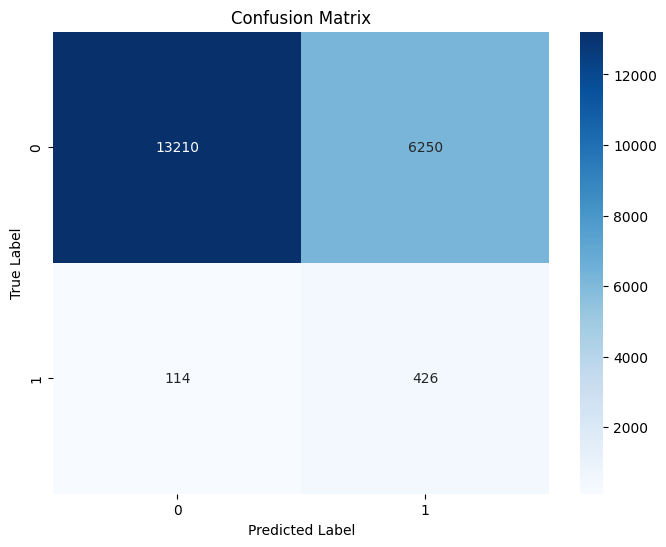

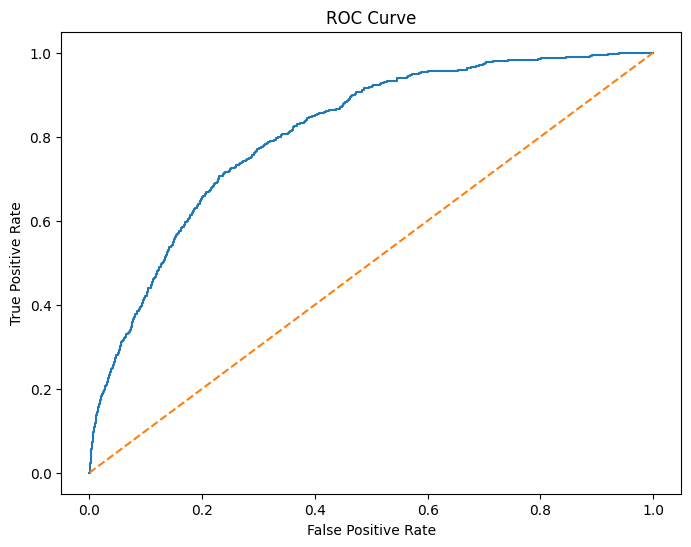

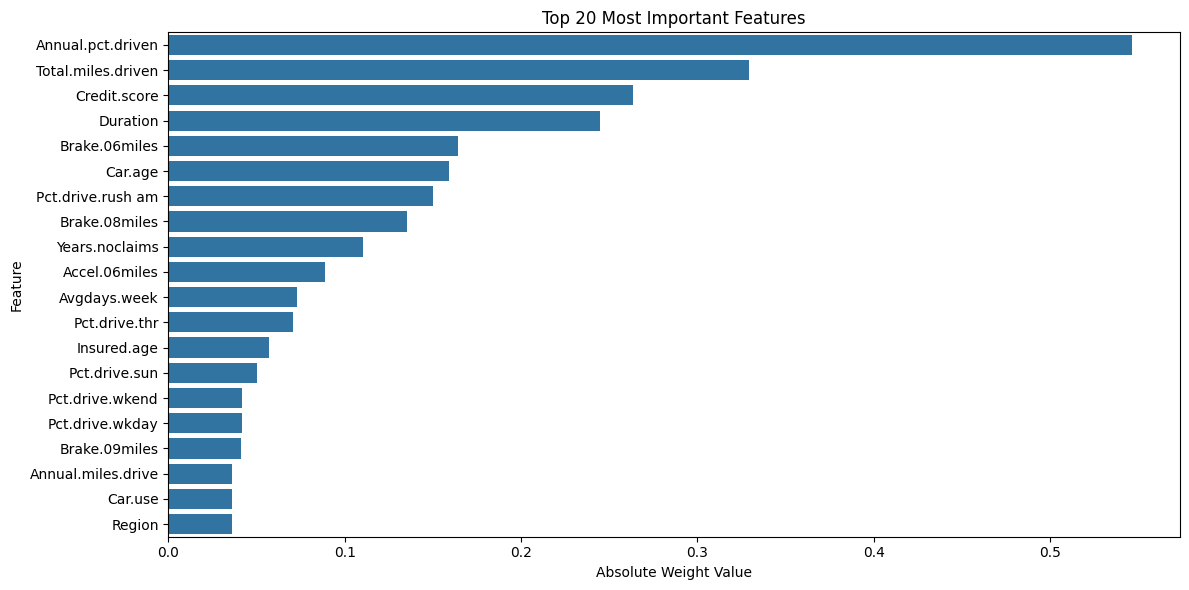

In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import shap
import matplotlib.pyplot as plt
import seaborn as sns

class CustomInsuranceModel:
    def __init__(self, learning_rate=0.01, n_iterations=1000, threshold=0.5):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.threshold = threshold
        self.weights = None
        self.bias = None

    def sigmoid(self, z):
        """Sigmoid activation function"""
        return 1 / (1 + np.exp(-np.clip(z, -250, 250)))

    def initialize_parameters(self, n_features):
        """Initialize weights and bias"""
        self.weights = np.zeros(n_features)
        self.bias = 0

    def forward_propagation(self, X):
        """Forward propagation step"""
        z = np.dot(X, self.weights) + self.bias
        return self.sigmoid(z)

    def compute_cost(self, y_pred, y_true):
        """Compute binary cross-entropy loss"""
        epsilon = 1e-15  # Small constant to avoid log(0)
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

    def compute_gradients(self, X, y_true, y_pred):
        """Compute gradients for weights and bias"""
        m = X.shape[0]
        dw = (1/m) * np.dot(X.T, (y_pred - y_true))
        db = (1/m) * np.sum(y_pred - y_true)
        return dw, db

    def fit(self, X, y):
        """Train the model using gradient descent"""
        self.initialize_parameters(X.shape[1])
        self.loss_history = []

        for i in range(self.n_iterations):
            # Forward propagation
            y_pred = self.forward_propagation(X)

            # Compute loss
            loss = self.compute_cost(y_pred, y)
            self.loss_history.append(loss)

            # Compute gradients
            dw, db = self.compute_gradients(X, y, y_pred)

            # Update parameters
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

            # Print progress every 100 iterations
            if (i + 1) % 100 == 0:
                print(f'Iteration {i + 1}/{self.n_iterations}, Loss: {loss:.4f}')

    def predict_proba(self, X):
        """Predict probability of class 1"""
        return self.forward_propagation(X)

    def predict(self, X):
        """Predict class labels"""
        probas = self.predict_proba(X)
        return (probas >= self.threshold).astype(int)

def preprocess_data(df):
    """Preprocess the insurance dataset"""
    # Create target variable
    df['ClaimYN'] = ((df['NB_Claim'] >= 1) & (df['AMT_Claim'] > 1000)).astype(int)

    # Drop unnecessary columns
    df = df.drop(['NB_Claim', 'AMT_Claim'], axis=1)

    # Encode categorical variables
    cat_cols = df.select_dtypes(include=['object']).columns
    encoders = {}

    for col in cat_cols:
        encoders[col] = LabelEncoder()
        df[col] = encoders[col].fit_transform(df[col])

    # Scale numerical features
    X = df.drop('ClaimYN', axis=1)
    y = df['ClaimYN']

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    return X_scaled, y, encoders, scaler

def handle_imbalance(X, y):
    """Handle class imbalance using SMOTE"""
    smote = SMOTE(random_state=42)
    X_balanced, y_balanced = smote.fit_resample(X, y)
    return X_balanced, y_balanced

def evaluate_model(y_true, y_pred, y_prob):
    """Evaluate model performance"""
    # Confusion matrix
    cm = pd.crosstab(y_true, y_pred, rownames=['Actual'], colnames=['Predicted'])

    # Calculate metrics
    tn, fp, fn, tp = cm.values.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * (precision * recall) / (precision + recall)

    print("\nModel Performance Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], '--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()

def analyze_feature_importance(model, X, feature_names):
    """Analyze feature importance using coefficients"""
    importance = np.abs(model.weights)
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance
    })
    feature_importance = feature_importance.sort_values('Importance', ascending=False)

    plt.figure(figsize=(12, 6))
    sns.barplot(data=feature_importance.head(20), x='Importance', y='Feature')
    plt.title('Top 20 Most Important Features')
    plt.xlabel('Absolute Weight Value')
    plt.tight_layout()
    plt.show()

    return feature_importance

def main():
    # Load data
    df = pd.read_csv('/content/drive/My Drive/telematics_syn.csv')

    # Preprocess data
    X, y, encoders, scaler = preprocess_data(df)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Handle class imbalance
    X_train_balanced, y_train_balanced = handle_imbalance(X_train, y_train)

    # Initialize and train model
    model = CustomInsuranceModel(learning_rate=0.01, n_iterations=1000)
    model.fit(X_train_balanced, y_train_balanced)

    # Make predictions
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)

    # Evaluate model
    evaluate_model(y_test, y_pred, y_prob)

    # Analyze feature importance
    feature_importance = analyze_feature_importance(
        model, X_test, df.drop(['ClaimYN', 'NB_Claim', 'AMT_Claim'], axis=1).columns
    )

    return model, encoders, scaler

if __name__ == "__main__":
    from sklearn.metrics import roc_curve
    model, encoders, scaler = main()